# Gaia, RR Lyrae stars, and Galactic Dust
## Technical Components
* Periodograms 
* Fourier decomposition
* Databases; SQL
* Python Web Queries
* Linear and NonLinear Optimization
* Markov Chain Monte Carlo
* Bayesian Modelling
* Data Visualization

In [1]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astropy.stats import LombScargle

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns; sns.set()
from scipy.optimize import curve_fit
import emcee
import dustmaps.sfd
import scipy.stats
import pymc3 as pm

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

/srv/app/venv/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%pip install -U setuptools setuptools_scm pep517
%pip install -U emcee

Requirement already up-to-date: setuptools in /srv/app/venv/lib/python3.6/site-packages
Requirement already up-to-date: setuptools_scm in /srv/app/venv/lib/python3.6/site-packages
Requirement already up-to-date: pep517 in /srv/app/venv/lib/python3.6/site-packages
Requirement already up-to-date: importlib_metadata; python_version < "3.8" in /srv/app/venv/lib/python3.6/site-packages (from pep517)
Requirement already up-to-date: toml in /srv/app/venv/lib/python3.6/site-packages (from pep517)
Requirement already up-to-date: zipp; python_version < "3.8" in /srv/app/venv/lib/python3.6/site-packages (from pep517)
You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Requirement already up-to-date: emcee in /srv/app/venv/lib/python3.6/site-packages
Requirement already up-to-date: numpy in /srv/app/venv/lib/python3.6/site-packages (from emc

In [4]:
pip install sympy

You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install symfit #restart the kernel to use updated packages!!!!

You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


1. Write an ADQL query to download the first 100 rows of the table for which a fundamental pulsation frequency (“pf”) has been measured and more than 40 clean epochs were obtained in the G-band. Submit your query using Astroquery and display the first 10 rows of the thus-obtained catalog

In [6]:
# writing ADQL query
q = Gaia.launch_job_async("SELECT TOP 100 rr.*, g2.phot_g_mean_mag, g2.phot_g_mean_flux, g2.phot_g_mean_flux_error \
        FROM gaiadr2.vari_rrlyrae as rr, (SELECT * FROM gaiadr2.gaia_source WHERE datalink_url IS NOT NULL) AS g2 \
        WHERE rr.source_id = g2.source_id \
        AND rr.pf IS NOT NULL \
        AND num_clean_epochs_g > 40")

INFO: Query finished. [astroquery.utils.tap.core]


In [7]:
# displaying first 10 rows
query = q.get_results()
query_df = query.to_pandas()
query_df[:10]

,solution_id,source_id,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,...,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,best_classification,phot_g_mean_mag,phot_g_mean_flux,phot_g_mean_flux_error
0,369295551293819386,5866125710834119808,0.452072,1.300320e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,57,17,16,6.536679,0.087367,b'RRab',19.869732,212.546157,2.772770
1,369295551293819386,5978435871487788288,0.648443,1.347062e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,0.033069,41,35,32,3.647337,0.064488,b'RRab',18.378452,839.393587,6.154775
2,369295551293819386,5704736782734774528,0.627005,2.980591e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,44,37,34,NaN,NaN,b'RRab',18.410284,815.140519,5.634281
3,369295551293819386,5816755332315333888,0.791397,1.509219e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,0.016617,68,65,61,0.334261,0.051369,b'RRab',17.609365,1704.512125,10.327683
4,369295551293819386,5821611776409134976,0.798234,1.349459e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013845,53,51,47,0.184756,0.051124,b'RRab',16.456299,4929.768432,28.321118
5,369295551293819386,5642603243216872576,0.825445,9.942079e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005504,52,45,43,NaN,NaN,b'RRab',17.360003,2144.593510,22.514193
6,369295551293819386,5813181197970338560,0.957651,2.921869e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002497,85,73,83,0.055899,0.050783,b'RRab',15.068896,17692.435162,117.449144
7,369295551293819386,5630421856972980224,0.657274,1.893473e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,77,64,70,0.053841,0.051493,b'RRab',17.944847,1251.433337,5.734255
8,369295551293819386,5810405553887250432,0.846902,3.934306e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005347,56,50,54,0.090980,0.050787,b'RRab',12.479338,192137.077313,931.101788
9,369295551293819386,5821156028840408576,0.777349,7.634924e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011115,55,45,46,0.168782,0.051107,b'RRab',15.447685,12481.654976,54.767846


2. Download the light curves (i.e., G-band magnitude vs. time, with magnitude uncertainties) for the 100 RR Lyrae stars in your table. Plot one of the light curves.

In [8]:
# getting raw light curve data for the 100 RR Lyrae stars in my table
lightcurve_data = []
for source_id in query['source_id']:
    url = (f'https://geadata.esac.esa.int/data-server/data?ID=Gaia+DR2+{source_id}'
        '&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&format=csv&band=G')
    lightcurve_data.append(url)

In [9]:
# magnitude uncertainty reported flux over error, and use standard error propagation
lightcurve_query = query_df.iloc[0]
magnitude_error = 2.5 * np.log10(lightcurve_query.phot_g_mean_flux / (lightcurve_query.phot_g_mean_flux - lightcurve_query.phot_g_mean_flux_error))
print(f'Magnitude Error: {magnitude_error}')

Magnitude Error: 0.014257165839265779


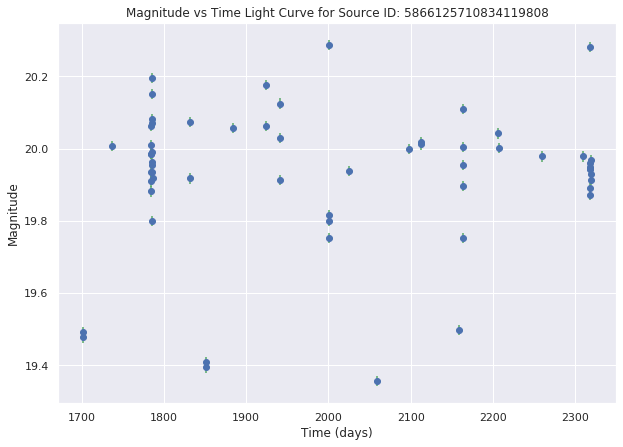

In [10]:
# plot G-band magnitude vs. time, with magnitude uncertainties, for one light curve

lightcurve = pd.read_csv(lightcurve_data[0])

plt.figure(figsize=(10,7))
plt.errorbar(x = lightcurve['time'], y = lightcurve['mag'], yerr = magnitude_error, fmt='o', ecolor='g', capthick=2)
plt.title("Magnitude vs Time Light Curve for Source ID: {}".format(query['source_id'][0]))
plt.xlabel("Time (days)")
plt.ylabel("Magnitude")
plt.show()


3.  Plot the periodogram for one light curve, marking your estimate of the period on the plot. Estimate the period and mean G-band magnitude of the 100 light curves you downloaded above.

In [11]:
periods = []
mean_G = []

for source_id in query['source_id']:
    url = (f'https://geadata.esac.esa.int/data-server/data?ID=Gaia+DR2+{source_id}'
        '&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&format=csv&band=G')
    data = pd.read_csv(url)
    frequency, power = LombScargle(data['time'], data['mag']).autopower(minimum_frequency=0,
                                                                        maximum_frequency=2,
                                                                        samples_per_peak=10)
    periods.append(frequency[np.argmax(power[1:])])
    mean_G.append(np.average(data['mag'][1:]))


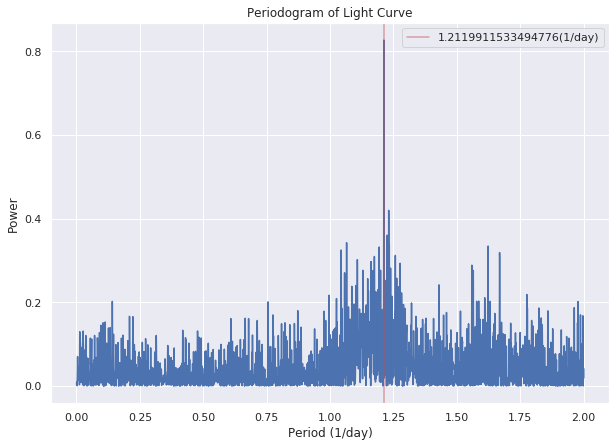

In [12]:
# plotting periodogram for one random light curve 

source_id = query['source_id'][10]
url = (f'https://geadata.esac.esa.int/data-server/data?ID=Gaia+DR2+{source_id}'
        '&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&format=csv&band=G')
data = pd.read_csv(url)

#apply lomb scargle to one star and visualize
frequency, power = LombScargle(data['time'], data['mag']).autopower(minimum_frequency=0,
                                                                    maximum_frequency=2,
                                                                    samples_per_peak=10)
best_frequency = frequency[np.argmax(power[1:])]

plt.figure(figsize=(10,7))
plt.plot(frequency, power)
plt.axvline(x=best_frequency, color = 'r', alpha = .5, label = '{}(1/day)'.format(best_frequency))
plt.title("Periodogram of Light Curve")
plt.xlabel("Period (1/day)")
plt.ylabel("Power")
plt.legend()


In [13]:
print(f'Estimated Period of the 100 light curves {np.mean(periods)} (1/day)')
print(f'Estimated Mean G-band Magnitude of the 100 light curves {np.average(mean_G)}')

Estimated Period of the 100 light curves 1.4949215051751903 (1/day)
Estimated Mean G-band Magnitude of the 100 light curves 17.075575443443274


4. Compare the periods you computed from the 100 light curves to the values reported in the vari_rrlyrae catalog. Comment on your results.

In [14]:
#find the difference between produced values and true values
diff_periods = []
diff_mean_G = []
for i in np.arange(0,100):
    diff_periods.append(np.abs(periods[i] - query['pf'][i]))
    diff_mean_G.append(np.abs(mean_G[i] - query['phot_g_mean_mag'][i]))

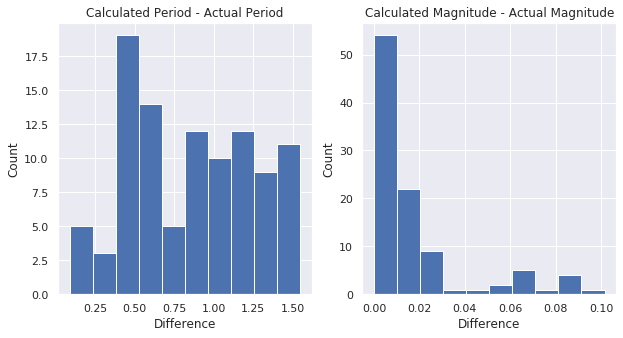

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(diff_periods)
ax[0].set_title('Calculated Period - Actual Period')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Difference')

ax[1].hist(diff_mean_G)
ax[1].set_title('Calculated Magnitude - Actual Magnitude')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Difference')
plt.subplots_adjust(hspace=0.4)

The calculated periods are within +/- 1.5 of the actual value. This difference might be from LombScargle picking up false signals in the data. The calculated magnitudes are very close to the actual values.

5. Show that if ω is known, then the problem of determining the remaining 2K + 1 free parameters can be re-cast as a linear algebra problem; i.e., y = Xβ. Here y is an array of the measured fluxes, X is a matrix that can be constructed from known quantities, and β is an array of unknowns. What are X and β? (write out the terms).

\begin{equation}
\begin{pmatrix} y(t_0) \\ y(t_1) \\ y(t_2) \\ . \\ . \\ . \end{pmatrix} = 
\begin{pmatrix} A^0_0 & a^0_1 & a^0_2 & ... & b^0_1 & b^0_2 & ... \\ A^1_0 & a^1_1 & a^1_2 & ... & b^1_1 & b^1_2 & ... \\ A^2_0 & a^2_1 & a^2_2 & ... & b^2_1 & b^2_2 & ... \\ A^0_0 & a^0_1 & a^0_2 & ... & b^0_1 & b^0_2 & ... \end{pmatrix} 
\begin{pmatrix} 1 \\ sin(𝜔t) \\ sin(2𝜔t) \\ . \\ . \\ . \end{pmatrix}
\end{equation}

In [16]:
from symfit import parameters, variables, sin, cos, Fit
# if this cell doesn't properly run, then I need to restart the kernel

def fourier_series(x, f, n=0):

    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

x, y = variables('x, y')
w, = parameters('w')
model_dict = {y: fourier_series(x, f=w, n=3)}
print('Example fourier series')
print(model_dict)

Example fourier series
{y: a0 + a1*cos(w*x) + a2*cos(2*w*x) + a3*cos(3*w*x) + b1*sin(w*x) + b2*sin(2*w*x) + b3*sin(3*w*x)}


6. For the star with Gaia DR2 id = 5813181197970338560 (which should be the 7th entry in your table), determine the series representations for K = 1, 3, 5, 7, and 9. Plot the phased light curve, the series representation on a fine grid, and the residuals between the data and series representation for each K.

In [17]:
query_id = query_df[query_df['source_id'] == 5813181197970338560]
query_id # shows that it is index 6, meaning 7th entry 

,solution_id,source_id,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,...,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,best_classification,phot_g_mean_mag,phot_g_mean_flux,phot_g_mean_flux_error
6,369295551293819386,5813181197970338560,0.957651,2.921869e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002497,85,73,83,0.055899,0.050783,b'RRab',15.068896,17692.435162,117.449144


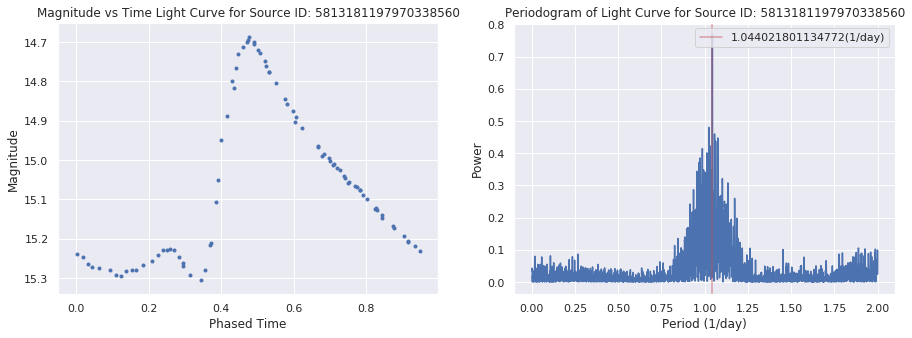

In [18]:
source_id = 5813181197970338560
url = (f'https://geadata.esac.esa.int/data-server/data?ID=Gaia+DR2+{source_id}'
        '&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&format=csv&band=G')
lightcurve = pd.read_csv(url)

frequency, power = LombScargle(lightcurve['time'], lightcurve['mag']).autopower(minimum_frequency=0,
                                                                                maximum_frequency=2, 
                                                                                samples_per_peak=10)
best_frequency = query['pf'][query['source_id'] == 5813181197970338560]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.invert_yaxis()
ax1.scatter(lightcurve['time'] % best_frequency, lightcurve['mag'], marker = '.')
ax1.set_title(f"Magnitude vs Time Light Curve for Source ID: {source_id}")
ax1.set_xlabel("Phased Time")
ax1.set_ylabel("Magnitude")

best_frequency = frequency[np.argmax(power[1:])]
ax2.plot(frequency, power)
ax2.axvline(x=best_frequency, color = 'r', alpha = .5, label = '{}(1/day)'.format(best_frequency))
ax2.set_title(f"Periodogram of Light Curve for Source ID: {source_id}")
ax2.set_xlabel("Period (1/day)")
ax2.set_ylabel("Power")
ax2.legend()


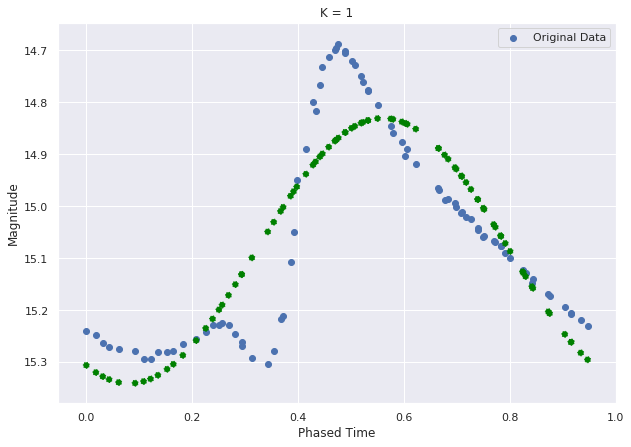

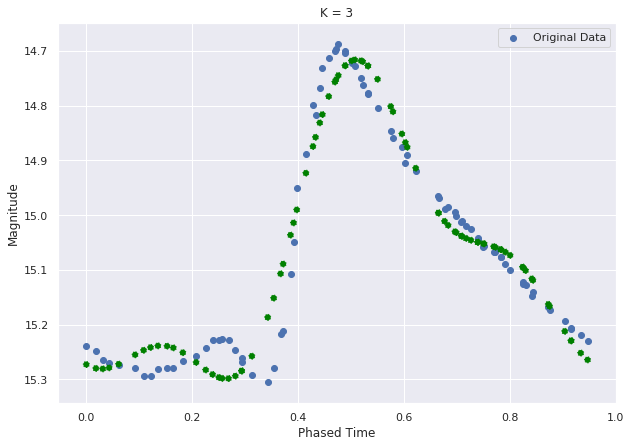

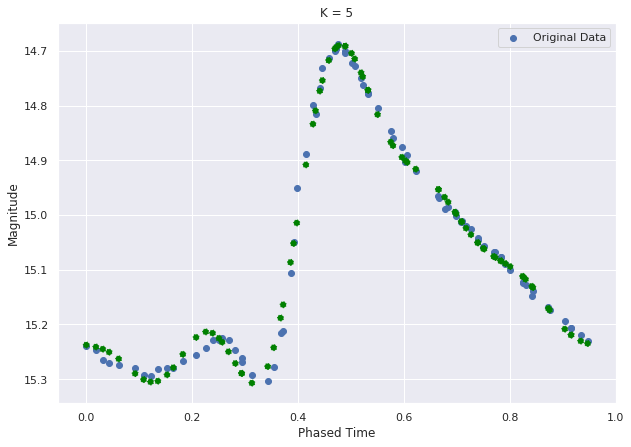

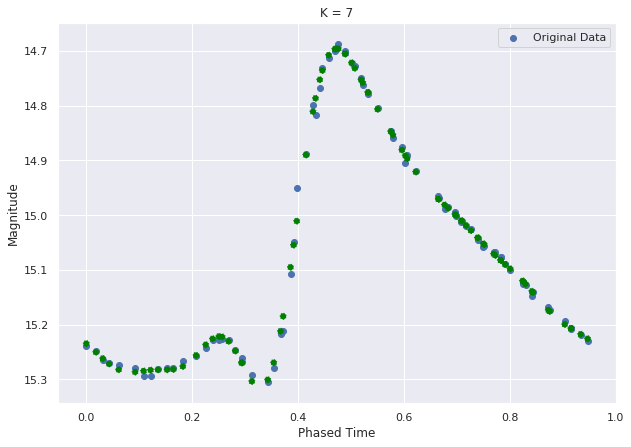

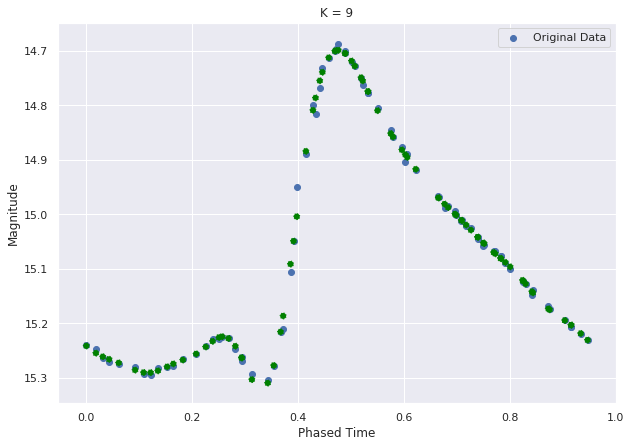

In [19]:
best_frequency = query['pf'][query['source_id'] == 5813181197970338560]
xdata = lightcurve['time'] % best_frequency
xdata = np.array(xdata)
ydata = lightcurve['mag']
ydata = np.array(ydata)

n_list = [1,3,5,7,9]

for n in n_list:
    x, y = variables('x, y')
    w = (2*np.pi)/best_frequency[0]
    model_dict = {y: fourier_series(x, f=w, n=n)}

    # Define a Fit object for this model and data
    fit = Fit(model_dict, x=xdata, y=ydata)
    fit_result = fit.execute()

    # Plot the result
    plt.figure(figsize = (10,7))
    plt.gca().invert_yaxis()
    plt.title(f'K = {n}')
    plt.xlabel("Phased Time")
    plt.ylabel("Magnitude")
    plt.scatter(xdata, ydata, label = 'Original Data')
    plt.scatter(xdata, fit.model(x=xdata, **fit_result.params).y, color='green', ls=':')
    plt.legend()
    plt.show()

7. How many terms is enough? Use cross-validation to find the optimal K. Designate 20% of the observed points as the cross-validation set. For K ranging from 1 to 25, calculate $χ2/N_{data}$ for both the training data (which enters y) and the cross-validation data (which does not). Plot this quantity as a function of K. Discuss what an appropriate value of K for this data set might be.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, random_state=0)

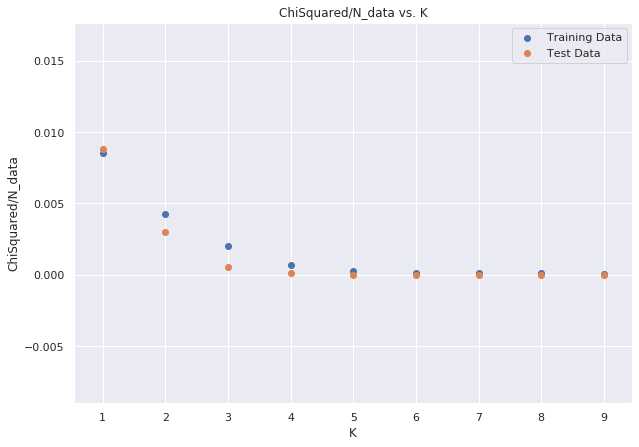

In [21]:
train_chisq_N = []
test_chisq_N = []

# K_list = range(1,26) # this was killing the kernel so I set the range to 10
K_list = range(1,10) # you can still see the trend with K ranging up to 10

for k in K_list:

    x, y = variables('x, y')
    w = (2*np.pi)/best_frequency[0]
    model_dict = {y: fourier_series(x, f=w, n=k)}

    # Define a Fit object for this model and data
    fit = Fit(model_dict, x=X_train, y=y_train)
    fit_result = fit.execute()
    train_chisq_N.append((fit_result.chi_squared)/len(X_train))

    # Define a Fit object for this model and data
    fit = Fit(model_dict, x=X_test, y=y_test)
    fit_result = fit.execute()
    test_chisq_N.append((fit_result.chi_squared)/len(X_test))


# Plot the result
plt.figure(figsize=(10,7))
plt.title('ChiSquared/N_data vs. K')
plt.scatter(K_list, train_chisq_N, label = 'Training Data')
plt.scatter(K_list, test_chisq_N, label = 'Test Data')
plt.ylim()
plt.xlabel('K')
plt.ylabel('ChiSquared/N_data')
plt.legend()
plt.show()

We want a small chi-squared value because it suggests that your observed data fits your expected data extremely well. As shown in the figure above, we can see from the test data that a K value of 4 or 5 would be sufficient for this data set. 

8. Using a value of K chosen based on (7), predict the expected magnitude of the star at t = 2329.0 (in
the units returned from the Gaia archive). Plot the light curve, showing the last Gaia data points (at
t ≈ 2320), the extrapolation over the next 10 days, and your best estimate for this time.

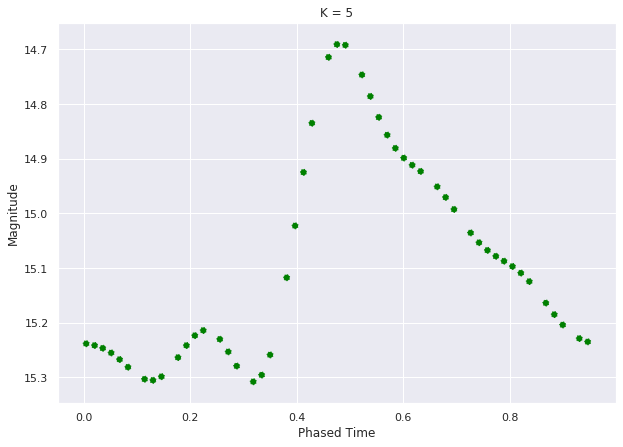

In [22]:
K = 8
t = 2329.0

best_frequency = query['pf'][query['source_id'] == 5813181197970338560]
xdata = lightcurve['time'] % best_frequency
xdata = np.array(xdata)
ydata = lightcurve['mag']
ydata = np.array(ydata)
x_ext = np.linspace(2320, 2330) % best_frequency
n = 5

x, y = variables('x, y')
w = (2*np.pi)/best_frequency[0]
model_dict = {y: fourier_series(x, f=w, n=n)}

# Define a Fit object for this model and data
fit = Fit(model_dict, x=xdata, y=ydata)
fit_result = fit.execute()

# Plot the result
plt.figure(figsize = (10,7))
plt.gca().invert_yaxis()
plt.title(f'K = {n}')
plt.xlabel("Phased Time")
plt.ylabel("Magnitude")
plt.scatter(x_ext, fit.model(x=x_ext, **fit_result.params).y, color='green', ls=':')
plt.show()

In [23]:
print(f'Estimate magnitude for star at t = 2329.0: {fit.model(x=2329, **fit_result.params).y}')

Estimate magnitude for star at t = 2329.0: [15.23589125]


9. When you calculated the average magnitude in part (3), you probably used some sort of mean in flux
space of the observed data points. This is not ideal because the observations are not necessarily evenly
sampled in phase. A more accurate value can be obtained by calculating the mean magnitude based
on the mean flux when averaging over one pulsation period. Now estimate the mean magnitude using
your Fourier model for each of the 100 light curves. Once again, the averaging should be done in flux
space, not magnitude space. Make a plot comparing your estimates of the mean G-band magnitude –
both from this estimate and from part (3) – to the estimate in the Gaia catalog. Also plot the residuals,
and comment on your results.

In [24]:
# estimate in Gaia catalog
gaia_mag = query_df['phot_g_mean_mag']

# magnitude estimate using fourier model
fourier_mag = []
for source_id in query['source_id']:
    url = (f'https://geadata.esac.esa.int/data-server/data?ID=Gaia+DR2+{source_id}'
        '&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&format=csv&band=G')
    data = pd.read_csv(url)
    frequency, power = LombScargle(data['time'], data['mag']).autopower(minimum_frequency=0,
                                                                        maximum_frequency=2,
                                                                        samples_per_peak=10)
    best_frequency = query['pf'][query['source_id'] == source_id]
    xdata = data['time'] % best_frequency
    xdata = np.array(xdata)
    ydata = data['mag']
    ydata = np.array(ydata)
    
    n = 5
    x, y = variables('x, y')
    w = (2*np.pi)/best_frequency[0]
    model_dict = {y: fourier_series(x, f=w, n=n)}

    # Define a Fit object for this model and data
    fit = Fit(model_dict, x=xdata, y=ydata)
    fit_result = fit.execute()
    
    fourier_mag.append(np.average(fit.model(x=xdata, **fit_result.params).y))
    

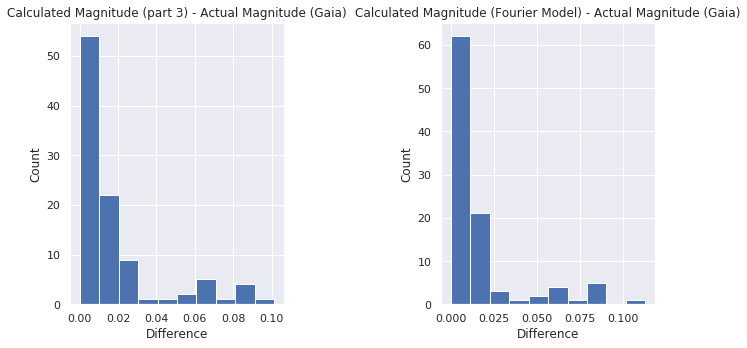

In [25]:
diff_fourier_G = []
for i in np.arange(0,100):
    diff_fourier_G.append(np.abs(fourier_mag[i] - query['phot_g_mean_mag'][i]))

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(diff_mean_G)
ax[0].set_title('Calculated Magnitude (part 3) - Actual Magnitude (Gaia)')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Difference')

ax[1].hist(diff_fourier_G)
ax[1].set_title('Calculated Magnitude (Fourier Model) - Actual Magnitude (Gaia)')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Difference')
plt.tight_layout(w_pad=4)

Using the Fourier model to estimate the mean G-band magnitude was very close to the magnitudes found in the Gaia catalogue and even slightly better than the estimates found in part (3), but was still very similar to the estimates found in part (3) . 

10.  Download light curves for the top 3 RR Lyrae in the vari_rrlyrae catalog
that have best_classification = “RRc”, mean G-band magnitudes brighter than 15, and more than 80
clean epochs in the G-band. Using a suitable number of terms, compute Fourier expansions for these
three light curves. Plot the phased light curves and overplot their Fourier models.
Repeat this for the top 3 RR Lyrae with best_classification = “RRab’. Compare the 6 phased light
curves and models, using some plotting scheme that makes it easy to see and compare their shapes.
Comment on the difference in light curve shape between the two classes. Do some reading (published
papers, Wikipedia, etc) about the difference between the classes.

In [31]:
# best_classification = 'RRc'
q2 = Gaia.launch_job_async("SELECT TOP 3 rr.*, g2.phot_g_mean_mag \
        FROM gaiadr2.vari_rrlyrae as rr, (SELECT * FROM gaiadr2.gaia_source WHERE datalink_url IS NOT NULL) AS g2 \
        WHERE rr.source_id = g2.source_id \
        AND best_classification = 'RRc' \
        AND g2.phot_g_mean_mag > 15 \
        AND num_clean_epochs_g > 80")


INFO: Query finished. [astroquery.utils.tap.core]


In [32]:
# best_classification = 'RRab'
q3 = Gaia.launch_job_async("SELECT TOP 3 rr.*, g2.phot_g_mean_mag \
        FROM gaiadr2.vari_rrlyrae as rr, (SELECT * FROM gaiadr2.gaia_source WHERE datalink_url IS NOT NULL) AS g2 \
        WHERE rr.source_id = g2.source_id \
        AND rr.pf IS NOT NULL \
        AND best_classification = 'RRab' \
        AND g2.phot_g_mean_mag > 15 \
        AND num_clean_epochs_g > 80")

INFO: Query finished. [astroquery.utils.tap.core]


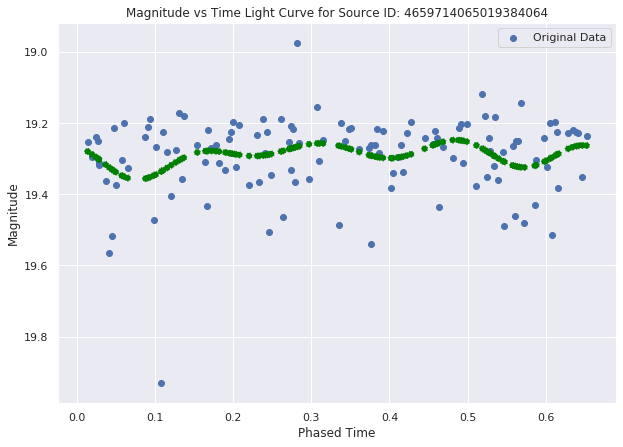

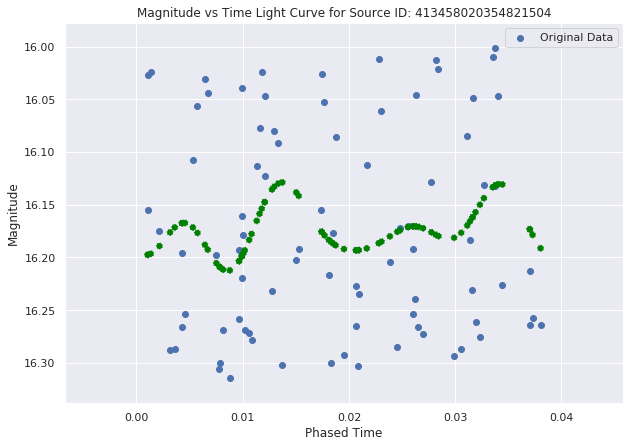

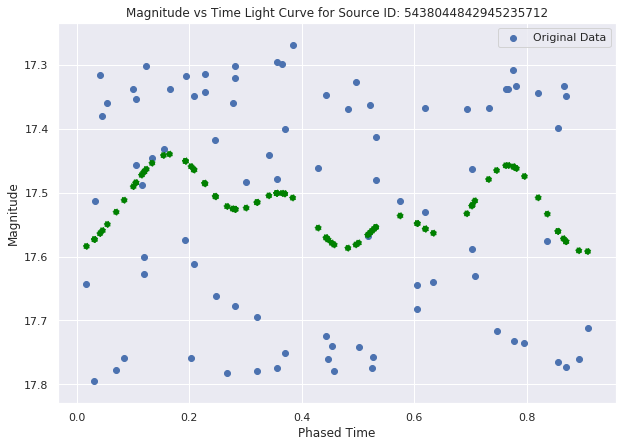

In [33]:
# plot the phased light curves and overplot their Fourier models
query2 = q2.get_results()

for source_id in query2['source_id']:
    url = (f'https://geadata.esac.esa.int/data-server/data?ID=Gaia+DR2+{source_id}'
        '&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&format=csv&band=G')
    data = pd.read_csv(url)
    frequency, power = LombScargle(data['time'], data['mag']).autopower(minimum_frequency=0,
                                                                        maximum_frequency=2,
                                                                        samples_per_peak=10)

    best_frequency = frequency[np.argmax(power[1:])] 
    # couldn't use the period found in the query because there were no results where pf exists
    
    xdata = data['time'] % best_frequency
    xdata = np.array(xdata)
    ydata = data['mag']
    ydata = np.array(ydata)

    n = 5
    x, y = variables('x, y')
    w = (2*np.pi)/best_frequency
    model_dict = {y: fourier_series(x, f=w, n=n)}

    # Define a Fit object for this model and data
    fit = Fit(model_dict, x=xdata, y=ydata)
    fit_result = fit.execute()

    # Plot the result
    plt.figure(figsize = (10,7))
    plt.gca().invert_yaxis()
    plt.title(f"Magnitude vs Time Light Curve for Source ID: {source_id}")
    plt.xlabel("Phased Time")
    plt.ylabel("Magnitude")
    plt.scatter(xdata, ydata, label = 'Original Data')
    plt.scatter(xdata, fit.model(x=xdata, **fit_result.params).y, color='green', ls=':')
    plt.legend()
    plt.show()

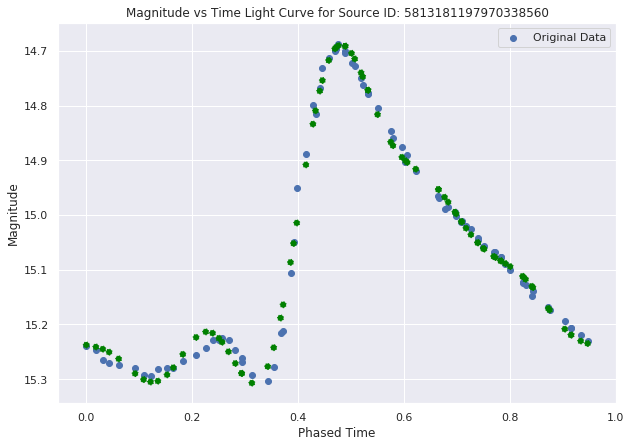

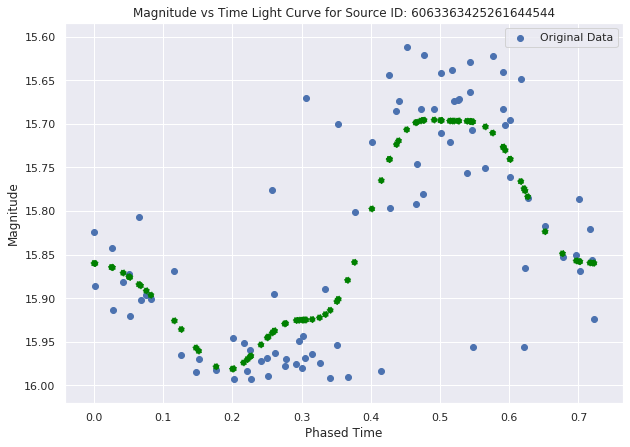

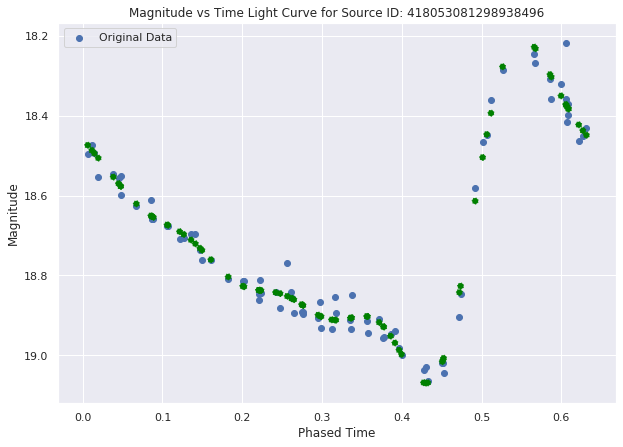

In [34]:
# plot the phased light curves and overplot their Fourier models
query3 = q3.get_results()


for source_id in query3['source_id']:
    url = (f'https://geadata.esac.esa.int/data-server/data?ID=Gaia+DR2+{source_id}'
        '&RETRIEVAL_TYPE=EPOCH_PHOTOMETRY&format=csv&band=G')
    data = pd.read_csv(url)
    frequency, power = LombScargle(data['time'], data['mag']).autopower(minimum_frequency=0,
                                                                        maximum_frequency=2,
                                                                        samples_per_peak=10)

    best_frequency = query3['pf'][query3['source_id'] == source_id][0]
    
    xdata = data['time'] % best_frequency
    xdata = np.array(xdata)
    ydata = data['mag']
    ydata = np.array(ydata)

    n = 5
    x, y = variables('x, y')
    w = (2*np.pi)/best_frequency
    model_dict = {y: fourier_series(x, f=w, n=n)}

    # Define a Fit object for this model and data
    fit = Fit(model_dict, x=xdata, y=ydata)
    fit_result = fit.execute()

    # Plot the result
    plt.figure(figsize = (10,7))
    plt.gca().invert_yaxis()
    plt.title(f"Magnitude vs Time Light Curve for Source ID: {source_id}")
    plt.xlabel("Phased Time")
    plt.ylabel("Magnitude")
    plt.scatter(xdata, ydata, label = 'Original Data')
    plt.scatter(xdata, fit.model(x=xdata, **fit_result.params).y, color='green', ls=':')
    plt.legend()
    plt.show()

I was able to obtain distinguishable lightcurves for the 'RRab' class whereas I was only able to get something resembling a scatterplot for the 'RRc' class. This can also be error in my own code. According to wikipedia, RRab make up 91% of all RR Lyrae stars and display typical lightcurves. RRc make up 9% of observed RR Lyrae stars, have shorter periods, and a more sinusoidal and symmetrical lightcurve.

11. Are the 6 light curves you plotted well-described by a single period, or is there evidence of intrinsic
scatter? Read about deviations from simple periodicity in RR Lyrae in Netzel et al. 2018 and discuss
your findings.

I was unable to find pf values for the 'RRc' lightcurves and instead tried to modulate the period with the best frequency found by LombScargle. I was able to find pf values for the 'RRab' lightcurves, however only 1 out of the 3 lightcurves were well-described by that single period whereas the others are more scattered and unclear. The lack of pf values for the 'RRc' lightcurves may be because 'period changes are common among RRc stars. For some observing seasons, these changes might resemble quasi-periodic modulation. (Netzel et al. 2018)'

12. First, we’ll need to use Gaia distances to estimate the absolute magnitude of RR Lyraes. This will
only work if there isn’t a lot of dust between us and the RR Lyraes. Explain why this is.
It turns out that most of the dust in the Milky Way is in the disk, at low Galactic latitude. Write
an ADQL query to select RR Lyrae stars that (a) have accurately measured distances, with parallax
errors of less than 20%, (b) are above or below the disk, with |b| > 30 degrees, where b is Galactic
latitude, and (c) are relatively nearby, with distances less than 4 kpc. To do this, you’ll need to join
the vari_rrlyrae and gaia_source catalogs. You should find about 500 objects.

In [35]:
q4 = Gaia.launch_job_async("SELECT rrl.pf, g2.* \
        FROM gaiadr2.gaia_source as g2, (SELECT * FROM gaiadr2.vari_rrlyrae WHERE pf IS NOT NULL) AS rrl \
        WHERE rrl.source_id = g2.source_id \
        AND g2.parallax_over_error > 5 \
        AND ABS(g2.b) > 30 \
        AND g2.parallax > 0.25")

INFO: Query finished. [astroquery.utils.tap.core]


In [36]:
query4 = q4.get_results()

print(len(query4['source_id']))

468


13. We’ll also want an estimate of the distance that uses our knowledge of Galactic structure to place a
prior on the distance inferred from parallaxes. A catalog of distances obtained in this way is described in
Bailer-Jones et al. 2018 and is available in the Gaia archive as external.gaiadr2_geometric_distance.
Write another ADQL query that gets these distance estimates and uncertainties for the targets obtained
in your query in part (12).

In [37]:
q5 = Gaia.launch_job_async("SELECT rrl.pf, gd.r_est, gd.r_lo, gd.r_hi, g2.* \
        FROM gaiadr2.gaia_source as g2, (SELECT * FROM gaiadr2.vari_rrlyrae WHERE pf IS NOT NULL) AS rrl, \
        (SELECT * FROM external.gaiadr2_geometric_distance) AS gd \
        WHERE rrl.source_id = g2.source_id \
        AND g2.source_id = gd.source_id \
        AND g2.parallax_over_error > 5 \
        AND ABS(g2.b) > 30 \
        AND g2.parallax > .25 \
        AND gd.r_est IS NOT NULL")

INFO: Query finished. [astroquery.utils.tap.core]


In [38]:
query5 = q5.get_results()
print(len(query5['source_id']))

468


14. Plot the distribution of targets you obtained in Galactic coordinates. Verify that your ADQL query
has removed stars in the Galactic disk.
Compare the distance estimate from the Bailer-Jones catalog to the naive distance estimate from
d = 1/$\omega$ (where $\omega$ is the parallax in appropriate units). Explain the trend you see.

Text(0, 0.5, 'Galactic Lat')

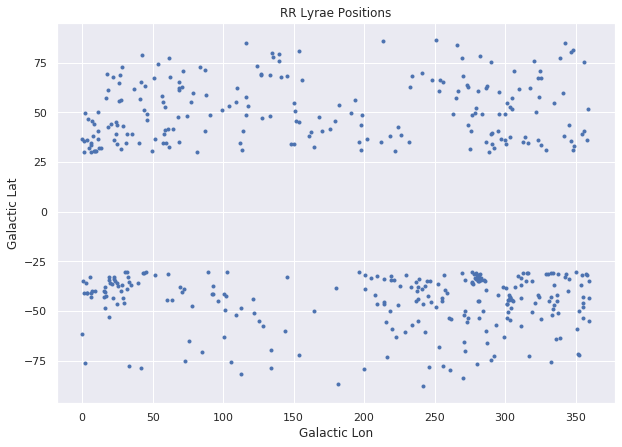

In [39]:
plt.figure(figsize=(10,7))
plt.scatter(query5['l'], query5['b'], marker = '.')
plt.title("RR Lyrae Positions")
plt.xlabel("Galactic Lon")
plt.ylabel("Galactic Lat")

Text(0, 0.5, 'Count')

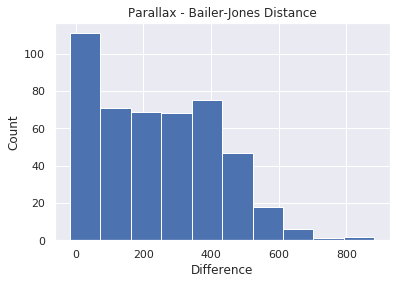

In [40]:
pc = [1000/x for x in query5['parallax']]
b = [x - y for x,y in zip(pc, query5['r_est'])]
plt.hist(b)
plt.title("Parallax - Bailer-Jones Distance")
plt.xlabel("Difference")
plt.ylabel("Count")

The Bailer-Jones distances are always less than the naive distance estimate of 1/parallax. This could mean that it is more accurate than providing an upper bound of distance.

15. Plot period vs. absolute G-band magnitude for all stars returned by your query.

In [41]:
abs_mag = [m + 5*np.log10(p/100) for m,p in zip(query5['phot_g_mean_mag'], query5['parallax'])]

Text(0, 0.5, 'Absolute Magnitude')

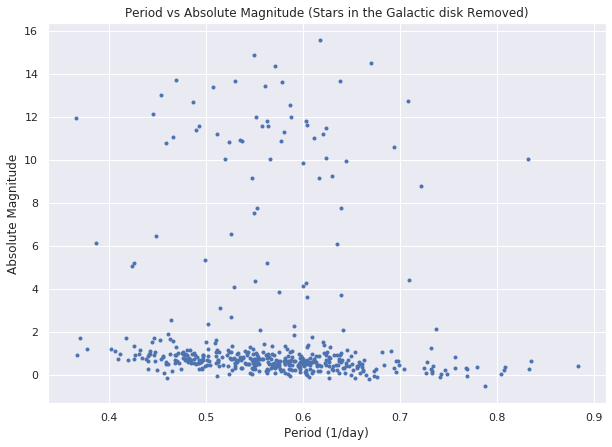

In [42]:
plt.figure(figsize=(10,7))
plt.scatter(query5['pf'], abs_mag, marker = '.')
plt.title("Period vs Absolute Magnitude (Stars in the Galactic disk Removed)")
plt.xlabel("Period (1/day)")
plt.ylabel("Absolute Magnitude")

16. You should see that the majority of the stars have similar absolute magnitude, but a non-negligible
fraction of them scatter far off the median relation. This is mostly due to incorrectly measured
parallaxes. Apply the quality cuts in Equations C1 and C2 of Lindegren et al. 2018 to the sample.
Then plot the period-luminosity relation again. Has the scatter decreased?

In [43]:
#apply quality cuts from Lindegren et al. 2018

q6 = Gaia.launch_job_async("SELECT rrl.pf, gd.r_est, gd.r_lo, gd.r_hi, g2.* \
        FROM gaiadr2.gaia_source as g2, (SELECT * FROM gaiadr2.vari_rrlyrae WHERE pf IS NOT NULL) AS rrl, \
        (SELECT * FROM external.gaiadr2_geometric_distance) AS gd \
        WHERE rrl.source_id = g2.source_id \
        AND g2.source_id = gd.source_id \
        AND g2.parallax_over_error > 5 \
        AND g2.parallax > .25 \
        AND ABS(g2.b) > 30 \
        AND SQRT(g2.astrometric_chi2_al/(astrometric_n_good_obs_al - 5)) < \
        1.2*.5*(1+EXP(-.2*(g2.phot_g_mean_mag-19.5))+ABS(1-EXP(-.2*(g2.phot_g_mean_mag-19.5)))) \
        AND 1+.015*POWER(g2.bp_rp,2) < g2.phot_bp_rp_excess_factor \
        AND g2.phot_bp_rp_excess_factor < 1.3+.06*POWER(g2.bp_rp,2)\
        AND gd.r_est IS NOT NULL")

INFO: Query finished. [astroquery.utils.tap.core]


In [44]:
query6 = q6.get_results()
print(len(query6['source_id']))

409


Scatter has decreased!


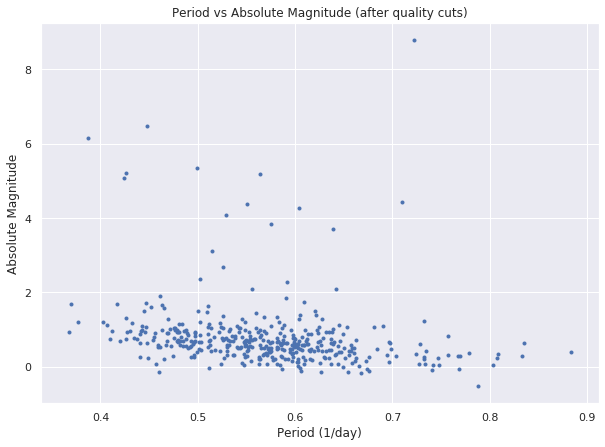

In [45]:
abs_mag = [m + 5*np.log10(p/100) for m,p in zip(query6['phot_g_mean_mag'], query6['parallax'])]
plt.figure(figsize=(10,7))
plt.scatter(query6['pf'], abs_mag, marker = '.')
plt.title("Period vs Absolute Magnitude (after quality cuts)")
plt.xlabel("Period (1/day)")
plt.ylabel("Absolute Magnitude")
print('Scatter has decreased!')

17.  Plot the period-absolute magnitude relation, including error bars on absolute magnitude due to distance
uncertainties, from the resulting cleaned sample.

Text(0, 0.5, 'Absolute Magnitude')

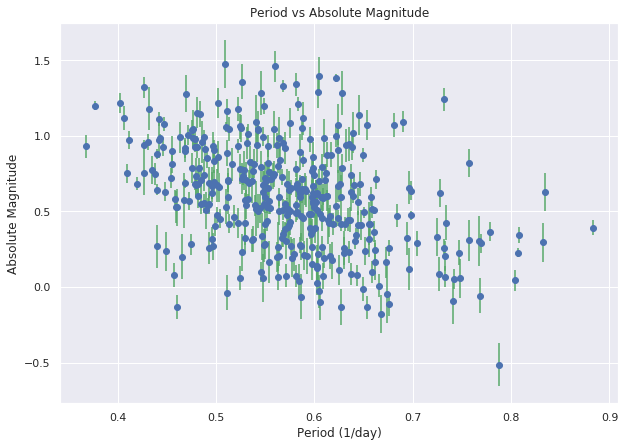

In [46]:
query6_df = query6.to_pandas()
#apply final manual cuts
cut = query6_df[(query6_df.phot_g_mean_mag + 5*np.log10(query6_df.parallax/100)) < 1.5]
per = cut['pf']
abs_mag = [m + 5*np.log10(p/100) for m,p in zip(cut['phot_g_mean_mag'], cut['parallax'])]
#find magnitude error from error in parallax through error propogation
error = np.array(cut['parallax_error']/cut['parallax'])

plt.figure(figsize=(10,7))
plt.errorbar(per, abs_mag, yerr = error, fmt = 'o', ecolor='g', capthick=2)
plt.title("Period vs Absolute Magnitude")
plt.xlabel("Period (1/day)")
plt.ylabel("Absolute Magnitude")

18. (i) Code up your own Metropolis-Hastings (M-H) MCMC sampler using a Gaussian proposal distribution. To qualitatively demonstrate convergence, plot x and ln P versus step number. Plot 50 random, independent samples from the posterior over the data. Does the spread between samples as a function of period seem consistent with what you’d expect given the data? Explain.

In [47]:
# function from source: https://jellis18.github.io/post/2018-01-02-mcmc-part1/

def mh_sampler(x0, lnprob_fn, prop_fn, prop_fn_kwargs={}, iterations=100000):
    
    # number of dimensions
    ndim = len(x0)
    
    # initialize chain, acceptance rate and lnprob
    chain = np.zeros((iterations, ndim))
    lnprob = np.zeros(iterations)
    accept_rate = np.zeros(iterations)
    
    # first samples
    chain[0] = x0
    lnprob0 = lnprob_fn(x0)
    lnprob[0] = lnprob0
    
    # start loop
    naccept = 0
    for ii in range(1, iterations):
        
        # propose
        x_star, factor = prop_fn(x0, **prop_fn_kwargs)
        
        # draw random uniform number
        u = np.random.uniform(0, 1)
        
        # compute hastings ratio
        lnprob_star = lnprob_fn(x_star)
        H = np.exp(lnprob_star - lnprob0) * factor
        
        # accept/reject step (update acceptance counter)
        if u < H:
            x0 = x_star
            lnprob0 = lnprob_star
            naccept += 1
        
        # update chain
        chain[ii] = x0
        lnprob[ii] = lnprob0
        accept_rate[ii] = naccept / ii
        
    return chain, accept_rate, lnprob

def gaussian_proposal(x, sigma=0.01):

    # Draw x_star
    x_star = x + np.random.randn(len(x)) * sigma

    # proposal ratio factor is 1 since jump is symmetric
    qxx = 1

    return (x_star, qxx)

def simple_gaussian_lnpost(x):

    mu = 0
    std = 1
    
    if x < 10 and x > -10:
        return -0.5 * (x-mu)**2 / std**2
    else:
        return -1e6
    
def run_mcmc_plots(sigma):
    x0 = np.random.randn(1)
    chain, ar, lnprob = mh_sampler(x0, simple_gaussian_lnpost, gaussian_proposal, 
                                   prop_fn_kwargs={'sigma':sigma})
    
    plt.figure(figsize=(15, 8))

    burn = int(0.1 * chain.shape[0])

    plt.subplot(221)
    plt.hist(chain[burn:, 0], 50, normed=True);
    plt.xlabel(r'$x$', fontsize=10)
    xx = np.linspace(-3.5, 3.5, 1000)
    plt.plot(xx, scipy.stats.norm(loc=0, scale=1).pdf(xx), lw=2)
    plt.title('Histogram of Samples', fontsize=15)

    plt.subplot(222)
    plt.plot(chain[burn:, 0])
    plt.xlabel('iteration', fontsize=10)
    plt.ylabel(r'$x$', fontsize=10)
    plt.axhline(0.0, lw=2, color='C1')
    plt.title('Sample vs Iteration', fontsize=15)

    plt.subplot(223)
    plt.plot(lnprob[burn:])
    plt.xlabel('iteration', fontsize=10)
    plt.ylabel('log-posterior', fontsize=10)
    plt.title('log-posterior vs Iteration', fontsize=15)

    plt.subplot(224)
    plt.plot(ar[burn:])
    plt.xlabel('iteration', fontsize=10)
    plt.ylabel('Acceptance Rate', fontsize=10)
    plt.title('Acceptance Rate vs Iteration', fontsize=15)
    
    plt.suptitle(r'$\sigma = {}$'.format(sigma), fontsize=15, y=1.02)
    plt.tight_layout()


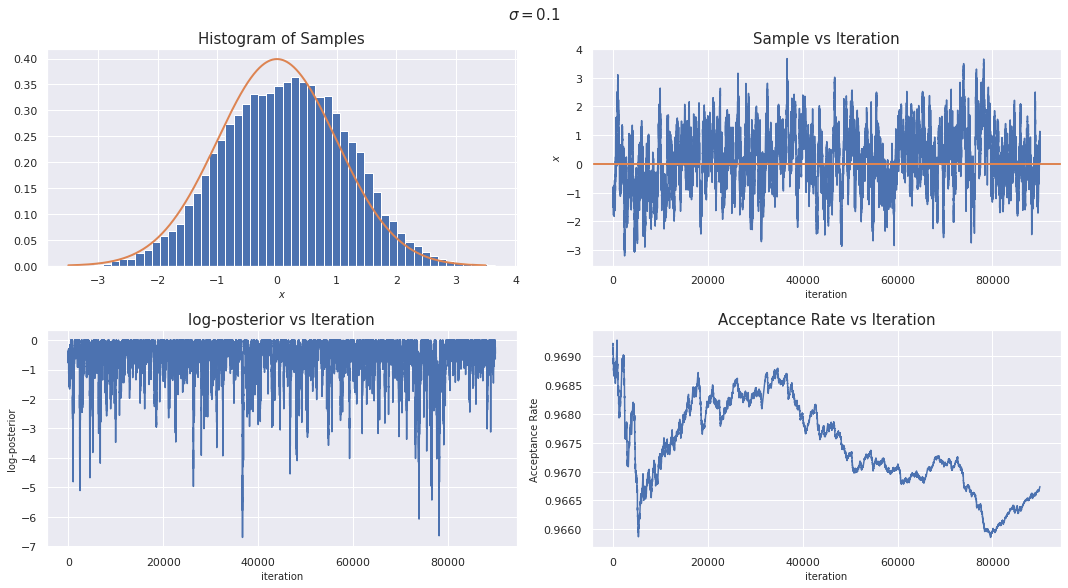

In [48]:
# Gaussian proposal distribution

run_mcmc_plots(0.1)

In [49]:
#likelihood function
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * np.log(x) + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

#prior
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 1 and -5 < b < 2 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

#posterior
def lnprobfn(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [50]:
#parameters for mcmc
ndim, nwalkers = 3, 32
pos = [(-.5,1,.01)+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [51]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobfn, args=(per, abs_mag, error))
sampler.run_mcmc(pos, 10000)

State([[-0.36510949  0.39640879 -0.63831729]
 [-0.68437008  0.22275264 -0.61120818]
 [-0.59379686  0.2627903  -0.6330779 ]
 [-0.56726182  0.25865242 -0.60670837]
 [-0.6321909   0.24895099 -0.72866985]
 [-0.70984283  0.1885158  -0.65193669]
 [-0.678723    0.21454656 -0.68045226]
 [-0.64426951  0.24755072 -0.66923262]
 [-0.49706621  0.31210502 -0.63428211]
 [-0.49225449  0.34480166 -0.68916799]
 [-0.45601976  0.33848374 -0.63649453]
 [-0.64773529  0.24095317 -0.69141331]
 [-0.54062424  0.312157   -0.70430529]
 [-0.58385326  0.27374788 -0.65828536]
 [-0.65195721  0.25206639 -0.77152337]
 [-0.61442529  0.24052798 -0.65753988]
 [-0.61061748  0.26011366 -0.65923341]
 [-0.2982591   0.44776949 -0.64722898]
 [-0.67608391  0.22586939 -0.64871034]
 [-0.6377089   0.22715054 -0.66347049]
 [-0.54577679  0.27200385 -0.61993953]
 [-0.47962582  0.31776955 -0.53717824]
 [-0.57512959  0.27240364 -0.66544012]
 [-0.65530779  0.24826969 -0.66086751]
 [-0.48764913  0.31462006 -0.66470057]
 [-0.76341962  0.18

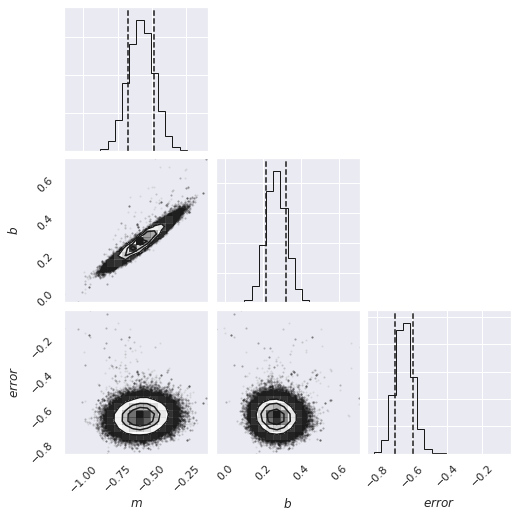

In [52]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$error$"], quantiles=[0.16, 0.84])

[-0.57900137  0.26807073 -0.64799586]
[0.09550069 0.05207072 0.04900088]


Text(0, 0.5, 'Absolute Magnitude')

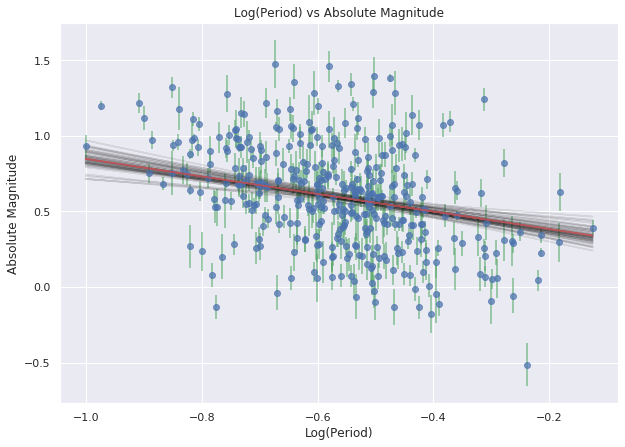

In [53]:
# plotting 50 random, independent samples from the posterior over the data
plt.figure(figsize=(10,7))
plt.cla()
print(np.percentile(samples, 50, axis=0))
print(np.percentile(samples, 50, axis=0) - np.percentile(samples, 16, axis=0))

for m, b, _ in samples[np.random.randint(len(samples), size=50)]:
    plt.plot(np.log(per), m*np.log(per)+b, color="k", alpha=0.1)
m,b,_ = np.percentile(samples, 50, axis=0)

plt.plot(np.log(per), m*np.log(per)+b, color="r", alpha=.8, zorder=10)
plt.errorbar(np.log(per), abs_mag, yerr = error, fmt = 'o', ecolor='g', capthick=.5, alpha = .7)
plt.title("Log(Period) vs Absolute Magnitude")
plt.xlabel("Log(Period)")
plt.ylabel("Absolute Magnitude")

I think the spread between samples as a function of period seem consistent with what I'd expect given the data because the trend is somewhat similar to the data.

18 (ii) Repeat your fit to the period-luminosity relation, using the same likelihood and priors as in (i).
But instead of using your M-H sampler, use the no-U-turn Hamiltonian Monte Carlo sampler
provided in pymc3. Discuss briefly what this sampler is and what some of the advantages are
of using it over Metropolis-Hastings. Add your likelihood function to your pymc3 model as a
“potential” term.

In [ ]:
"""
import theano

with pm.Model() as model:
    f = theano.function(model.vars, [model.logpt] + model.deterministics)
    
    def log_prob_func(params):
        dct = model.bijection.rmap(params)
        args = (dct[k.name] for k in model.vars)
        results = f(*args)
        return tuple(results)

    res = pm.find_MAP()
    vec = model.bijection.map(res)
    initial_blobs = log_prob_func(vec)[1:]
    dtype = [(var.name, float, np.shape(b)) for var, b in zip(model.deterministics, initial_blobs)]
    
    # Then sample as usual
    ndim, nwalkers = 3, 32
    pos = [(-.5,1,.01)+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_func, blobs_dtype=dtype)
    sampler.run_mcmc(pos, 10000, progress=True)
"""

I couldn't figure how to code this, but NUTS is an extension to the Hamiltonian Monte Carlo that eliminates the need to set a number of steps. Metropolis-Hastings takes samples from a target distribution by first making a random proposal for new parameter values and then accepting or rejecting the proposal. However, the problem is that it is too random amd tends to get stuck in narrow regions of the target. NUTS is an approach for adaptively finding a good number of steps by trying to figure out when the path starts to turn around. It is much more efficient that Metropolis-Hastings.

18. (iii) Repeat step (ii), but instead of enrolling your likelihood function into the pymc3 model explicitly,
simply tell pymc3 your model: namely, that you expect values of MG at a given P to have a
mean value µ = a log (P/day) + b, and to follow a normal distribution with mean µ and variance $σ^{2}_{scatter} + σ^{2}_{i}$, where $σ_i$ are the measurement uncertainties.

In [54]:
with pm.Model() as model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of outcome
    mu = alpha*np.log10(per) + beta
    
    mean, sigma = 0, 1
    vals = pm.Normal('x', mu=mean,sigma=sigma)
    
    step = pm.NUTS()
    
    # draw 10000 posterior samples
    trace = pm.sample(10000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, sigma, beta, alpha]
Sampling 4 chains, 31 divergences: 100%|██████████| 42000/42000 [00:20<00:00, 2009.01draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd693311080>,
      dtype=object)

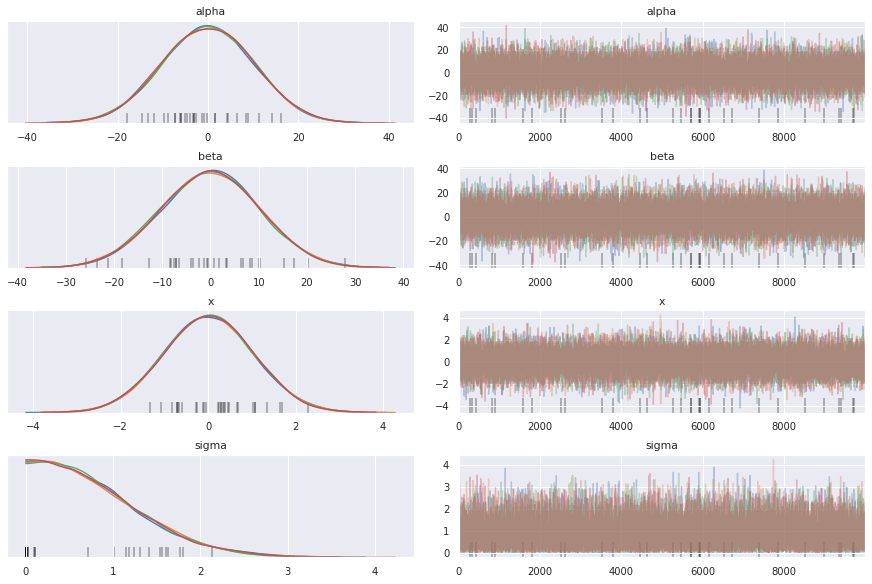

In [55]:
pm.traceplot(trace)

In [56]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.033,10.033,-19.139,18.388,0.059,0.056,29157.0,16298.0,29151.0,24561.0,1.0
beta,-0.021,10.136,-19.479,18.662,0.059,0.056,29540.0,16324.0,29542.0,24435.0,1.0
x,0.013,1.008,-1.860,1.928,0.006,0.006,29517.0,16327.0,29510.0,24558.0,1.0
sigma,0.809,0.599,0.000,1.877,0.004,0.003,28612.0,28612.0,20059.0,12733.0,1.0


19. Many of the RR Lyrae identified by Gaia were also observed by the WISE survey, which observed the whole sky in the near-infrared. Cross-match your sample of clean RR-Lyrae stars with WISE.

In [57]:
q7 = Gaia.launch_job_async("SELECT rrl.pf, ov.w2mpro, g2.* \
        FROM gaiadr2.gaia_source as g2, (SELECT * FROM gaiadr2.vari_rrlyrae WHERE pf IS NOT NULL) AS rrl, \
        (SELECT * FROM gaiadr2.allwise_best_neighbour) AS bn, \
        (SELECT * FROM gaiadr1.allwise_original_valid) AS ov \
        WHERE rrl.source_id = g2.source_id \
        AND bn.source_id = g2.source_id \
        AND bn.allwise_oid = ov.allwise_oid \
        AND g2.parallax_over_error > 5 \
        AND g2.parallax > .25 \
        AND ABS(g2.b) > 30 \
        AND SQRT(g2.astrometric_chi2_al/(astrometric_n_good_obs_al - 5)) < \
        1.2*.5*(1+EXP(-.2*(g2.phot_g_mean_mag-19.5))+ABS(1-EXP(-.2*(g2.phot_g_mean_mag-19.5)))) \
        AND 1+.015*POWER(g2.bp_rp,2) < g2.phot_bp_rp_excess_factor \
        AND g2.phot_bp_rp_excess_factor < 1.3+.06*POWER(g2.bp_rp,2)")

INFO: Query finished. [astroquery.utils.tap.core]


Text(0, 0.5, 'Absolute Magnitude')

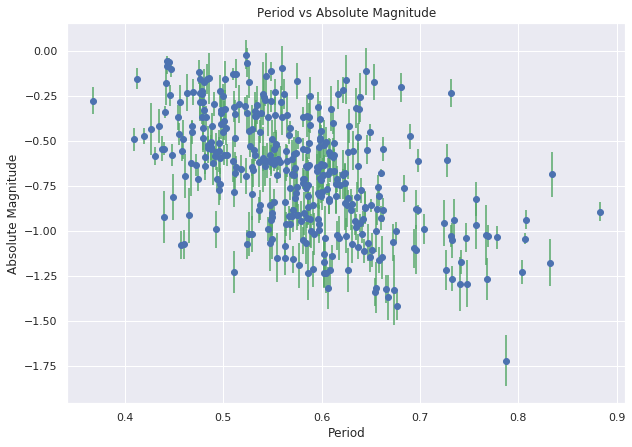

In [58]:
query7 = q7.get_results()
query7_df = query7.to_pandas()
wise_cut = query7_df[(query7_df.w2mpro + 5*np.log10(query7_df.parallax/100)) <0]
abs_mag_w2 = [m + 5*np.log10(p/100) for m,p in zip(wise_cut['w2mpro'], wise_cut['parallax'])]
per_w2 = wise_cut['pf']
error_w2 = np.array(wise_cut['parallax_error']/wise_cut['parallax'])

plt.figure(figsize=(10,7))
plt.errorbar(per_w2, abs_mag_w2, yerr = error_w2, fmt = 'o', ecolor='g', capthick=2)
plt.title("Period vs Absolute Magnitude")
plt.xlabel("Period")
plt.ylabel("Absolute Magnitude")

20. Repeat step (18), now using the WISE “W2” magnitude rather than the G band. You can simply use
the magnitude reported in the Wise catalog; you don’t need to average any light curves. You can skip
directly to fitting method (iii).

In [59]:
# I don't understand pymc3, so I'm using the emcee method I used above
pos = [(-.5,-.5,.5)+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler_w2 = emcee.EnsembleSampler(nwalkers, ndim, lnprobfn, args=(per_w2, abs_mag_w2, error_w2))
sampler_w2.run_mcmc(pos, 10000)

State([[-0.90063164 -1.16152822 -1.02687804]
 [-0.90957853 -1.1719979  -0.90661444]
 [-0.96031374 -1.18427282 -0.89941839]
 [-1.17625187 -1.32158746 -0.91497056]
 [-1.04456877 -1.2617273  -1.00731348]
 [-0.92674868 -1.17115907 -0.93611506]
 [-1.07059967 -1.28413057 -0.93516894]
 [-0.91133807 -1.187661   -0.91432821]
 [-0.94609482 -1.18805133 -0.95075359]
 [-1.11216075 -1.29977925 -0.94423458]
 [-0.99046316 -1.21706056 -0.98373136]
 [-1.15341121 -1.33232082 -0.9638174 ]
 [-1.13112354 -1.28116572 -0.91030478]
 [-0.97559949 -1.21499411 -0.96194105]
 [-0.9185457  -1.19206841 -0.94953085]
 [-0.91052719 -1.19272237 -0.91388555]
 [-0.92770892 -1.1897509  -0.86222183]
 [-1.02573329 -1.22959774 -0.92851884]
 [-1.01838078 -1.23871636 -0.91980447]
 [-0.99598476 -1.22501205 -0.96408469]
 [-0.96706993 -1.2147131  -0.89047372]
 [-0.91768333 -1.13624559 -0.86086381]
 [-0.99529141 -1.20919578 -0.87431984]
 [-0.83851208 -1.12229646 -0.8996176 ]
 [-1.04006769 -1.25120733 -0.9553678 ]
 [-0.93952399 -1.20

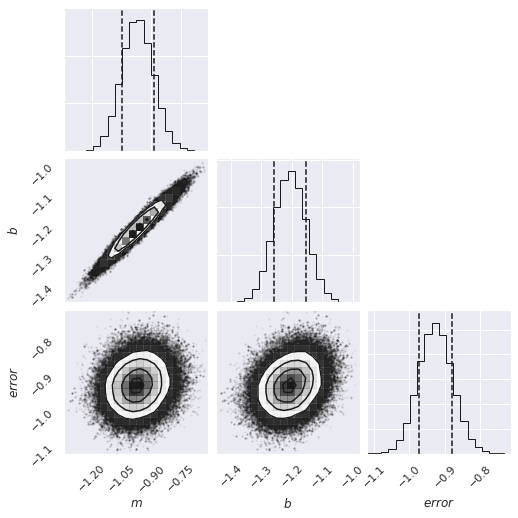

In [60]:
# corner plots
samples_w2 = sampler_w2.chain[:, 200:, :].reshape((-1, ndim))
fig = corner.corner(samples_w2, labels=["$m$", "$b$", "$error$"], quantiles=[0.16, 0.84])

Text(0, 0.5, 'Absolute Magnitude')

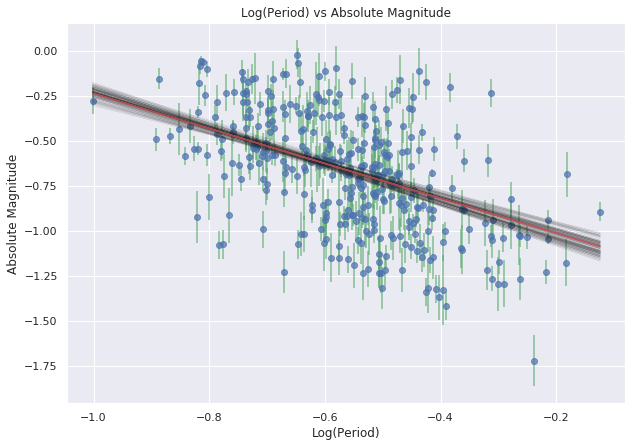

In [61]:
# period-luminosity relation
plt.figure(figsize=(10,7))
for m, b, _ in samples_w2[np.random.randint(len(samples_w2), size=50)]:
    plt.plot(np.log(per_w2), m*np.log(per_w2)+b, color="k", alpha=0.1, zorder=10)
m,b,_ = np.percentile(samples_w2, 50, axis=0)
plt.plot(np.log(per_w2), m*np.log(per_w2)+b, color="r", alpha=.8, zorder=10)
plt.errorbar(np.log(per_w2), abs_mag_w2, yerr = error_w2, fmt = 'o', ecolor='g', capthick=.5, alpha = .7)
plt.title("Log(Period) vs Absolute Magnitude")
plt.xlabel("Log(Period)")
plt.ylabel("Absolute Magnitude")

21. Comment on the differences between your inferred period-luminosity relations in the optical and in the
near-infrared. In which band is the period-luminosity relationship steeper?

In [62]:
print('G-band')
print(np.percentile(samples, 50, axis=0))
print(np.percentile(samples, 50, axis=0) - np.percentile(samples, 16, axis=0))

print('\n W2 band')
print(np.percentile(samples_w2, 50, axis=0))
print(np.percentile(samples_w2, 50, axis=0) - np.percentile(samples_w2, 16, axis=0))


G-band
[-0.57900137  0.26807073 -0.64799586]
[0.09550069 0.05207072 0.04900088]

 W2 band
[-0.97003998 -1.20641666 -0.92699444]
[0.07992061 0.05282303 0.0468448 ]


G-band: $(-0.57893355\pm 0.0942002)\log(p) + (0.2681132 \pm 0.05210562)$ <br>
W2 band: $(-0.96994501\pm 0.0798892)\log(p) + (-1.2065557 \pm 0.05215343)$ <br>

The W2 band is steeper than the G-band and has a more negative y-intercept.

22. Compare your derived period-luminosity relations to results in the literature, which can be found in
Beaton et al. 2018 or Klein & Bloom 2014. You can compare your G-band relation to their V-band
relation. If there are systematic differences between your results and the literature, what might account
for them?

From Klein & Bloom 2014: <br>
V-band: $(−0.4091 ± 0.2370)\log(p) + (0.4319 ± 0.0184)$ <br>
W2 band: $(−2.2337 ± 0.1249)\log(p) + (−0.4583 ± 0.0112)$ <br>

While my results and the literature yield similar results in trend (the infrared band is steeper than the visible band and the visible band results are very similar), the Klein & Bloom's slope for the infrared band is a lot steeper and the y-intercept less negative than my results. These systematic differences might come from the quality cuts that were made when getting the initial data that we use to fit the distribution. The prior and parameters for the MCMC model itself could have contributed to errors as well.

23. Following a similar procedure to the one in step (18), derive a period-color relation for RR Lyrae stars
in the Gaia bands. That is, a relation between log(period) and the Gaia GBP − GRP color. You will
need to calculate color uncertainties using the uncertainties in BP and RP flux. You don’t need to use
your own sampler, but can skip right to the pymc3 version.

In [63]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 5 and -3 < b < 3 and -4 < lnf < 4:
        return 0.0
    return -np.inf

In [64]:
cut_pc = query6_df[(query6_df.bp_rp + 5*np.log10(query6_df.parallax/100)) < -11]
per_pc = cut_pc['pf']


abs_mag_pc = np.subtract([m + 5*np.log10(p/100) for m,p in zip(cut_pc['phot_bp_mean_mag'], cut_pc['parallax'])], 
                         [m + 5*np.log10(p/100) for m,p in zip(cut_pc['phot_rp_mean_mag'], cut_pc['parallax'])])

# calculate error from parallax error and apparent magnitude error from flux error
p_error_pc = np.array(cut_pc['parallax_error']/cut_pc['parallax'])
m_error_pc = np.sqrt(np.square(5*cut_pc['phot_bp_mean_flux_error']/cut_pc['phot_bp_mean_flux']) + 
                     np.square(5*cut_pc['phot_rp_mean_flux_error']/cut_pc['phot_rp_mean_flux']))
error_pc = np.sqrt(np.square(p_error_pc) + np.square(m_error_pc))

In [65]:
# using the emcee method because I'm really lost with pymc3
pos = [(-.5,.5,.2)+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler_pc = emcee.EnsembleSampler(nwalkers, ndim, lnprobfn, args=(per_pc, abs_mag_pc, error_pc))
sampler_pc.run_mcmc(pos, 10000)

State([[-0.07297436  0.63076919 -3.4303487 ]
 [ 0.23598071  0.77155828 -3.55928486]
 [ 0.19857127  0.75790484 -3.93764494]
 [-0.01616542  0.66902469 -3.44786884]
 [ 0.18447188  0.7550321  -3.93763613]
 [ 0.16390274  0.74243715 -3.44453642]
 [ 0.21269043  0.75387373 -3.80767916]
 [ 0.25503828  0.80619723 -3.68813659]
 [ 0.0116302   0.6674072  -3.70166508]
 [-0.07047949  0.62761582 -3.81170391]
 [-0.01158485  0.67003139 -3.7960395 ]
 [ 0.04486957  0.69202575 -3.96244918]
 [-0.16740661  0.555087   -3.5557787 ]
 [ 0.04831162  0.68319001 -3.69402878]
 [ 0.07613575  0.66584768 -3.5210128 ]
 [-0.01020622  0.64965222 -3.52387417]
 [ 0.25553872  0.76012469 -3.47967407]
 [ 0.1531212   0.76050912 -3.68815964]
 [ 0.02940835  0.65594174 -3.83509364]
 [ 0.14331737  0.73516806 -3.49559764]
 [-0.0800566   0.61172515 -3.69816469]
 [ 0.01183883  0.66563572 -3.15780312]
 [ 0.11734252  0.73037396 -3.34659274]
 [ 0.062244    0.69370419 -3.96878096]
 [ 0.06162752  0.69505877 -3.6065623 ]
 [ 0.15856069  0.72

[ 0.10113231  0.71059244 -3.64556911]
[0.10178355 0.05638564 0.25164553]


Text(0, 0.5, 'Absolute Magnitude')

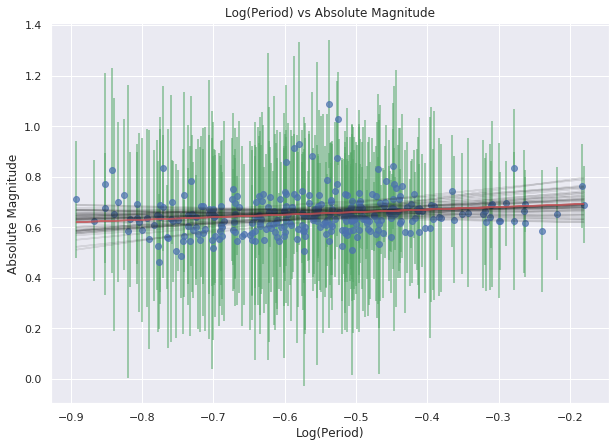

In [66]:
plt.figure(figsize=(10,7))
plt.cla()
samples_pc = sampler_pc.chain[:, 200:, :].reshape((-1, ndim))
print(np.percentile(samples_pc, 50, axis=0))
print(np.percentile(samples_pc, 50, axis=0) - np.percentile(samples_pc, 16, axis=0))

for m, b, _ in samples_pc[np.random.randint(len(samples_pc), size=50)]:
    plt.plot(np.log(per_pc), m*np.log(per_pc)+b, color="k", alpha=0.1,zorder = 10)
m,b,_ = np.percentile(samples_pc, 50, axis=0)

plt.plot(np.log(per_pc), m*np.log(per_pc)+b, color="r", alpha=.8, zorder = 10)
plt.errorbar(np.log(per_pc), abs_mag_pc, yerr = error_pc, fmt = 'o', ecolor='g', capthick=.5, alpha = .7)
plt.title("Log(Period) vs Absolute Magnitude")
plt.xlabel("Log(Period)")
plt.ylabel("Absolute Magnitude")

24. Write an ADQL query to download the full Gaia RR Lyrae catalog (i.e., no longer excluding stars with
imprecise parallaxes or low galactic latitude) and cross-match it with the Gaia source catalog.

In [74]:
q8 = Gaia.launch_job_async("SELECT rrl.pf, g_absorption, g2.source_id, g2.l, g2.b, g2.bp_rp \
        FROM gaiadr2.gaia_source as g2, (SELECT * FROM gaiadr2.vari_rrlyrae WHERE pf IS NOT NULL \
        AND g_absorption IS NOT NULL) AS rrl \
        WHERE rrl.source_id = g2.source_id \
        AND g2.bp_rp IS NOT NULL \
        AND g_absorption IS NOT NULL")

INFO: Query finished. [astroquery.utils.tap.core]


In [75]:
query8 = q8.get_results()
print(query8['source_id'])

     source_id     
-------------------
5884553250832851200
5865284545760288512
5879361185109392896
5891074862297700224
5891523192489234944
5887646280147139072
5875025222347011968
5866125710834119808
5887169534434303360
5887438747319318016
                ...
6790114119817249280
6790784753191284480
6791540663139837824
6791551387674133632
6791668790603840640
6792122064272937344
6792315479537427968
6793839265213595520
6794115753731913472
6794882663091256320
6795868547065591936
Length = 54268 rows


25. Calculate the color excess, $E(G_{BP} − G_{RP}) = (G_{BP} − G_{RP})_{observed} − (G_{BP} − G_{RP})_{intrinsic}$, for all RR
Lyraes in the catalog. From this, calculate AG, the G-band extinction, for each star.

In [86]:
# use posterior to find the intrinsic color based from the period
m,b,_ = np.percentile(samples_pc, 50, axis=0)
bp_rp_intr = [m*np.log10(p)+b for p in query8['pf']]
E = query8['bp_rp'] - bp_rp_intr
a_g = 2*E
a_g

3.1247874796745854
3.974404016939496
3.5826222631915225
4.408426998113255
3.4922972577167757
2.013279969416396
3.1711545584479377
2.5101037156908594
2.904645631433564
2.9460170663504286
1.6512769184490779


26. Compare your calculated AG values to the “G_absorption” value provided in the RR Lyrae catalog.

Text(0, 0.5, 'Count')

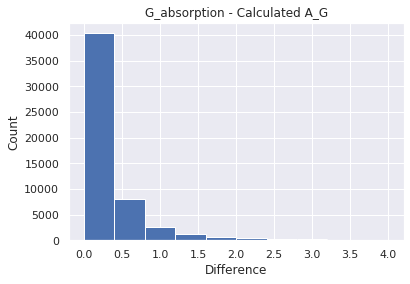

In [87]:
diff = np.abs(query8['g_absorption'] - a_g)
plt.hist(diff, range = (0,4))
plt.title("G_absorption - Calculated A_G")
plt.xlabel("Difference")
plt.ylabel("Count")

Most of the calculated values are extremely close to the true value.

27. Plot a 2-d map of $E(G_{BP} − G_{RP})$ as a function of Galactic longitude and latitude, using an Aitoff
projection.

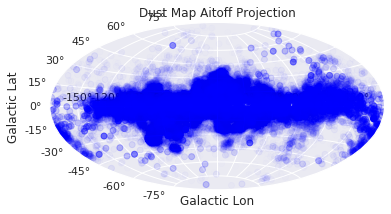

In [88]:
from astropy.coordinates import SkyCoord

#create correc galactic coordinates usable with aitoff projection
coords = SkyCoord(query8['l'], query8['b'], frame='galactic')
lon_rad = coords.l.wrap_at(180 * u.deg).radian
lat_rad = coords.b.radian
max_e = np.amax(E)
alphas = E/max_e
alphas = [0 if x<0 else x for x in alphas]
#create variable transparency for each point
rgba_colors = np.zeros((len(alphas),4))
rgba_colors[:,2] = 1.0

rgba_colors[:, 3] = np.array(alphas)

plt.figure()
plt.subplot(111, projection="aitoff")
plt.title("Dust Map Aitoff Projection")
plt.xlabel("Galactic Lon")
plt.ylabel("Galactic Lat")
plt.grid(True)
plt.scatter(lon_rad, lat_rad, color = rgba_colors)
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.show()

The distribution of RR Lyrae stars in the catalog might not all be uniform due to the different classification of RR Lyrae stars and the filters I used.

28. Plot the SFD optical reddening map, E (B − V ), sampled at the same positions as your RR Lyrae
map. Does the general structure of your map agree with SFD? What about the small-scale details?

In [90]:
dustmaps.sfd.fetch()
sfd = dustmaps.sfd.SFDQuery()
reden = sfd(coords)

 62.4 MiB of 64.0 MiB |  33.3 MiB/s |################## |  97% | ETA:   0:00:00

 63.2 MiB of 64.0 MiB |  33.0 MiB/s |################## |  98% | ETA:   0:00:00

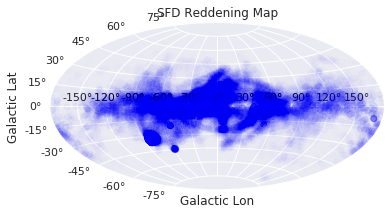

In [91]:
max_e = np.amax(reden)
alphas = reden/max_e
alphas = [0 if x<0 else x for x in alphas]
rgba_colors = np.zeros((len(alphas),4))
rgba_colors[:,2] = 1.0
rgba_colors[:, 3] = alphas

plt.figure()
plt.subplot(111, projection="aitoff")
plt.title("SFD Reddening Map")
plt.xlabel("Galactic Lon")
plt.ylabel("Galactic Lat")
plt.grid(True)
plt.scatter(lon_rad, lat_rad, color = rgba_colors)
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.show()

The general structure of my map agrees with the SFD reddening map. My map seems to contain more points than the SFD reddening map, however details in topography are lost.

29. Do you expect your map to look exactly like SFD? Hint: think about how the SDF map is constructed.
What are the differences between what it measured and what your map measures?

I do not expect my map to look exactly like SFD although they should look similar. The SFD map and the Aitoff projection map both measure exctinction/color excess. The SFD map was calibrated by using the colors of the brightest cluster galaxies and also did not test for coherent residuals as a function of longitude (Hudson 1998). Furthermore, Schlegel, Finkbeiner, and Davis 1998 use the equation $R_V ≡ A(V)/E(B−V) ≈ 3.1$ whereas our lab uses $R_V ≡ A(V)/E(B−V) ≈ 2$